# Sentiment Prediction from Movie Review (IMDB)

Goal: Predict positive or negative sentiments from movie reviews

Dataset: [IMDB Movie reviews sentiment classification](https://keras.io/datasets/)

In [1]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import helper

helper.reproducible(seed=9)
sns.set()

Using TensorFlow backend.


## Load the data

In [2]:
from keras.datasets import imdb

max_words = 20000  # most common words
max_length = 500 # words per review limit

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words,
                                                      skip_top=0,
                                                      maxlen=max_length)
# dictionaries ids <-> words
word2id = imdb.get_word_index()
id2word = {i: word for word, i in word2id.items()}

print("Training reviews: {}".format(len(x_train)))
print("Testing reviews: {}".format(len(x_test)))

print("\nReview:")
print([id2word.get(i, " ") for i in x_train[2]])
print("\nLabel: {}".format(y_train[2]))
print("0: negative, 1:positive")

Training reviews: 25000
Testing reviews: 20947

Review:
['the', 'as', 'there', 'in', 'at', 'by', 'br', 'of', 'sure', 'many', 'br', 'of', 'proving', 'no', 'only', 'women', 'was', 'than', "doesn't", 'as', 'you', 'never', 'of', 'hat', 'night', 'that', 'with', 'ignored', 'they', 'bad', 'out', 'superman', 'plays', 'of', 'how', 'star', 'so', 'stories', 'film', 'comes', 'defense', 'date', 'of', 'wide', 'they', "don't", 'do', 'that', 'had', 'with', 'of', 'hollywood', 'br', 'of', 'my', 'seeing', 'fan', 'this', 'of', 'pop', 'out', 'body', 'shots', 'in', 'having', 'because', 'cause', "it's", 'stick', 'passing', 'first', 'were', 'enjoys', 'for', 'from', 'look', 'seven', 'sense', 'from', 'me', 'and', 'die', 'in', 'character', 'as', 'cuban', 'issues', 'but', 'is', 'you', 'that', "isn't", 'one', 'song', 'just', 'is', 'him', 'less', 'are', 'strongly', 'not', 'are', 'you', 'that', 'different', 'just', 'even', 'by', 'this', 'of', 'you', 'there', 'is', 'eight', 'when', 'it', 'part', 'are', "film's", 'lov

## Process the data

In [3]:
from keras.preprocessing.sequence import pad_sequences

# padding
x_train = pad_sequences(x_train, max_length)
x_test = pad_sequences(x_test, max_length)

# one-hot encoding the target
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("Training set:  x-shape={}  y-shape={}".format(x_train.shape, y_train.shape))
print("Testing  set:  x-shape={}  y-shape={}".format(x_test.shape, y_test.shape))

Training set:  x-shape=(25000, 500)  y-shape=(25000, 2)
Testing  set:  x-shape=(20947, 500)  y-shape=(20947, 2)


## Deep Neural Network

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 10)           200000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 5000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 40008     
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
Total params: 240,026.0
Trainable params: 240,026.0
Non-trainable params: 0.0
_________________________________________________________________
Training ....
CPU times: user 2.38 s, sys: 280 ms, total: 2.66 s
Wall time: 2.7 s


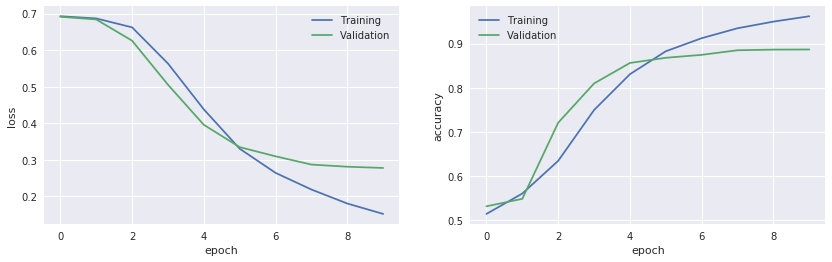


Training loss:  	0.1523
Validation loss: 	0.2780

Training accuracy: 	0.96
Validation accuracy:	0.89

Model saved at models/sentiment_IMDB_model.h5


In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.embeddings import Embedding

model = Sequential()
model.add(Embedding(max_words, 10, input_length=max_length))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Training ....')
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=1)]
%time history = model.fit(x_train, y_train, batch_size=1024, epochs=10, verbose=0, validation_split = 0.3, callbacks=callbacks)
helper.show_training(history)

model_path = os.path.join("models", "sentiment_IMDB_model.h5")
model.save(model_path)
print("\nModel saved at",model_path)

## Evaluate and Predict

In [5]:
model = keras.models.load_model(model_path)
print("Model loaded:", model_path)

score = model.evaluate(x_test, y_test, verbose=0)
print("\nTest Accuracy: {:.2f}\n".format(score[1]))

Model loaded: models/sentiment_IMDB_model.h5

Test Accuracy: 0.88



In [6]:
import re
import nltk

def review_to_ids(review):
    """ Convert a raw review string into a sequence of ids """
    
    review = re.sub(r"[^a-zA-Z0-9]", " ", review)  # remove non-letters
    review = review.lower()  # convert to lowercase
    words = review.split()  # tokenize
    ids = [word2id.get(i, 0) for i in words]
    ids = pad_sequences([ids],max_length)
    
    return ids


def predict(review):
    """ Show the probability of positive sentiment given a string review """
    my_ids = review_to_ids(review)
    print("Positive Probability: {:.2f}".format(model.predict(my_ids, verbose=0)[0][1]))    

In [7]:
my_review = """The writer and director did well on his first movie, but this one is an absolute nonsense. 
I like complicated, non-linear, and abstract movies, although nothing can be learn from this messy script. 
The only thing worth it is the photography """
predict(my_review)

Positive Probability: 0.50


In [8]:
# http://www.imdb.com/user/ur12188407/
my_review2 = """ In short, this is one of the best sci-fi movies I have seen in a LONG time. Sam Rockwell 
plays it perfect, making the viewer feel his isolation and lonelieness. For a low budget film, the few effect 
shots work seamlessly. I'm trying to remain spoiler free, so I won't bother to explain the plot. If you like 
older and more story/character driven sci-fi, such as 2001: A Space Odyssey, than chances are you will love 
this movie. If you aren't a huge fan of sci-fi, take a chance with this one. You may find it a very rewarding 
experience. I loved this movie, and I can't stop thinking about it. In Moon, you may begin to think that 
everything is a big cliché, but than with all of the seemingly cliché plot points, Moon changes them into 
something entirely original and unexpected. It is an excellent piece of art and I have a strong feeling not 
enough people will see and appreciate it like I did."""
predict(my_review2)

Positive Probability: 0.87
